In [1]:
!pip install pandas
import pandas as pd
!pip install numpy
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
!pip install matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
import keras
from keras.layers import Input
from tensorflow.keras.applications import ResNet50
!pip install scikit-image
import skimage.transform as skTrans

Defaulting to user installation because normal site-packages is not writeable
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(CertificateError("hostname 'pypi.org' doesn't match either of 'internet.ut.ac.ir', 'utnet.ut.ac.ir', 'internet1.ut.ac.ir', 'hsinform.ut.ac.ir'"))) - skipping
Defaulting to user installation because normal site-packages is not writeable
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(CertificateError("hostname 'pypi.org' doesn't match either of 'internet.ut.ac.ir', 'utnet.ut.ac.ir', 'internet1.ut.ac.ir', 'hsinform.ut.ac.ir'"))) - skipping
Defaulting to user installation because normal site-packages is not writeable
Could not fetch URL ht

2023-07-14 14:03:34.790688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 14:03:35.237802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-14 14:03:35.237850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-14 14:03:35.237854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Defaulting to user installation because normal site-packages is not writeable
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(CertificateError("hostname 'pypi.org' doesn't match either of 'internet.ut.ac.ir', 'utnet.ut.ac.ir', 'internet1.ut.ac.ir', 'hsinform.ut.ac.ir'"))) - skipping


In [2]:
#reading datas

total_data = pd.read_csv("./total_data_finally.csv")

In [3]:
total_data

,Unnamed: 0,Subject ID,Research Group
0,0,002_S_0295,CN
1,1,002_S_0413,CN
2,2,002_S_0559,CN
3,3,002_S_0619,AD
4,4,002_S_0685,CN
...,...,...,...
285,285,131_S_0691,AD
286,286,131_S_1389,MCI
287,287,133_S_0525,CN
288,288,136_S_0429,MCI


In [4]:
#collect the ids of patients
PID = total_data["Subject ID"]
group = total_data["Research Group"]
PID = np.array(PID)
group = np.array(group)
MCI = total_data[total_data["Research Group"]=="MCI"]
for i in MCI["Subject ID"]:
    print (i, end=" ")

002_S_0729 002_S_0782 002_S_0954 002_S_1070 002_S_1155 002_S_1268 003_S_0908 003_S_1057 003_S_1074 003_S_1122 005_S_0222 005_S_0324 005_S_0448 005_S_0546 005_S_0572 005_S_1224 006_S_0322 006_S_0521 006_S_0675 006_S_1130 007_S_0041 007_S_0101 007_S_0128 007_S_0249 007_S_0293 007_S_0344 007_S_0414 007_S_0698 009_S_1030 009_S_1199 010_S_0161 010_S_0422 011_S_0168 011_S_0241 011_S_0326 011_S_0362 011_S_0856 011_S_0861 011_S_1080 011_S_1282 012_S_0634 012_S_1292 012_S_1321 013_S_0240 013_S_0325 013_S_0860 013_S_1120 013_S_1186 013_S_1275 014_S_0169 014_S_0557 014_S_0563 014_S_0658 016_S_0354 016_S_0590 016_S_0702 016_S_0769 016_S_1028 016_S_1092 016_S_1117 016_S_1121 016_S_1138 016_S_1149 016_S_1326 018_S_0142 018_S_0155 018_S_0406 018_S_0450 021_S_0141 021_S_0178 021_S_0231 021_S_0273 021_S_0276 021_S_0332 021_S_0424 021_S_0626 022_S_0004 022_S_0044 022_S_0544 023_S_0030 023_S_0331 023_S_0376 023_S_0604 023_S_1247 029_S_1073 094_S_1293 100_S_0006 100_S_0892 100_S_0995 123_S_0050 123_S_0108

In [5]:
#function for finding the paths of image data

def path_data(category,patient,region):
    paths = []
    for i in range(0,len(patient)):
        path = "./"+patient[i]+"/"+region+".nii.gz"
        paths.append(path)
    return paths

In [6]:
#function for reading MRIs with Niftii format with Nibabel

def read_nifti_file(filepath):
    scan = nib.load(filepath).get_fdata()
    return scan

In [7]:
group.shape

(290,)

In [8]:
#making one-hot-endcoded labels
#CN -> [0,0,1]
#MCI -> [0,1,0]
#AD -> [1,0,0]
labels_OHE = []

for i in group:
    if i =='CN':
        label_s = [0,0,1]
        label_s = np.array(label_s)
        labels_OHE.append(label_s)
    elif i =='MCI':
        label_s = [0,1,0]
        label_s = np.array(label_s)
        labels_OHE.append(label_s)
    else:
        label_s = [1,0,0]
        label_s = np.array(label_s)
        labels_OHE.append(label_s)

labels_OHE = np.array(labels_OHE)
labels_OHE.shape

(290, 3)

In [9]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

In [10]:
!pip install torch
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [11]:
!pip install torch-summary
from torchsummary import summary
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
    
summary(resnet, (3, 256, 256))
fc_inputs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(fc_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 3), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

resnet = resnet.to('cuda:0')
summary(resnet, (3, 256, 256))

# alexnet = models.alexnet(pretrained=True)
# for param in alexnet.parameters():
#     param.requires_grad = False
    
# summary(alexnet, (3, 256, 256))
# alexnet.classifier[6] = nn.Linear(4096, 3)
# alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
# alexnet

    
# # Change the final layer of AlexNet Model for Transfer Learning
# resnet.classifier[6] = nn.Linear(4096, num_classes)
# resnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
# resnet

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


/home/hedieh/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hedieh/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-2                   [-1, 64, 64, 64]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-2                   [-1, 64, 64, 64]  

In [12]:
transform = transforms.ToTensor()

In [13]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [7]:
#image to png Sagital
import matplotlib.image
MCI = total_data[total_data["Research Group"]=="MCI"]
for i in MCI["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/MCI/"+i+"/CSF.nii.gz").get_fdata()[128,:,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/MCI/"+i+"/GM.nii.gz").get_fdata()[128,:,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/MCI/"+i+"/WM.nii.gz").get_fdata()[128,:,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/MCI/sagital/"+i+".png", image)

#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [8]:
from PIL import Image

AD = total_data[total_data["Research Group"]=="AD"]
for i in AD["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/AD/"+i+"/CSF.nii.gz").get_fdata()[128,:,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/AD/"+i+"/GM.nii.gz").get_fdata()[128,:,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/AD/"+i+"/WM.nii.gz").get_fdata()[128,:,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/AD/sagital/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [9]:
CN = total_data[total_data["Research Group"]=="CN"]
for i in CN["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/CN/"+i+"/CSF.nii.gz").get_fdata()[128,:,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/CN/"+i+"/GM.nii.gz").get_fdata()[128,:,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/CN/"+i+"/WM.nii.gz").get_fdata()[128,:,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/CN/sagital/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [10]:
#image to png Axial
import matplotlib.image
MCI = total_data[total_data["Research Group"]=="MCI"]
for i in MCI["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/MCI/"+i+"/CSF.nii.gz").get_fdata()[:,128,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/MCI/"+i+"/GM.nii.gz").get_fdata()[:,128,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/MCI/"+i+"/WM.nii.gz").get_fdata()[:,128,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/MCI/axial/"+i+".png", image)

#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [11]:
from PIL import Image

AD = total_data[total_data["Research Group"]=="AD"]
for i in AD["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/AD/"+i+"/CSF.nii.gz").get_fdata()[:,128,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/AD/"+i+"/GM.nii.gz").get_fdata()[:,128,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/AD/"+i+"/WM.nii.gz").get_fdata()[:,128,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/AD/axial/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [12]:
CN = total_data[total_data["Research Group"]=="CN"]
for i in CN["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/CN/"+i+"/CSF.nii.gz").get_fdata()[:,128,:]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/CN/"+i+"/GM.nii.gz").get_fdata()[:,128,:]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/CN/"+i+"/WM.nii.gz").get_fdata()[:,128,:]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/CN/axial/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [15]:
#image to png Coronal
import matplotlib.image
MCI = total_data[total_data["Research Group"]=="MCI"]
for i in MCI["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/MCI/"+i+"/CSF.nii.gz").get_fdata()[:,:,128]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/MCI/"+i+"/GM.nii.gz").get_fdata()[:,:,128]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/MCI/"+i+"/WM.nii.gz").get_fdata()[:,:,128]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/MCI/coronal/"+i+".png", image)

#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [16]:
from PIL import Image

AD = total_data[total_data["Research Group"]=="AD"]
for i in AD["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/AD/"+i+"/CSF.nii.gz").get_fdata()[:,:,128]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/AD/"+i+"/GM.nii.gz").get_fdata()[:,:,128]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/AD/"+i+"/WM.nii.gz").get_fdata()[:,:,128]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/AD/coronal/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

In [17]:
CN = total_data[total_data["Research Group"]=="CN"]
for i in CN["Subject ID"]:
    image = None
    del image
    im = None
    del im
    csf = nib.load("./data/CN/"+i+"/CSF.nii.gz").get_fdata()[:,:,128]
    x,y = csf.shape
    csf = csf.reshape(x,y,1)
    gm = nib.load("./data/CN/"+i+"/GM.nii.gz").get_fdata()[:,:,128]
    x,y = gm.shape
    gm = gm.reshape(x,y,1)
    wm = nib.load("./data/CN/"+i+"/WM.nii.gz").get_fdata()[:,:,128]
    x,y = wm.shape
    wm = wm.reshape(x,y,1)
    image = np.concatenate((csf,gm,wm),axis=2)
#     image = image.astype(np.uint8)
#     im = Image.fromarray(image)
#     im = im.astype(np.uint8)
    matplotlib.image.imsave("./data/images/CN/coronal/"+i+".png", image)
#     cv2.imwrite("./data/images/MCI/"+i+".jpeg", image)

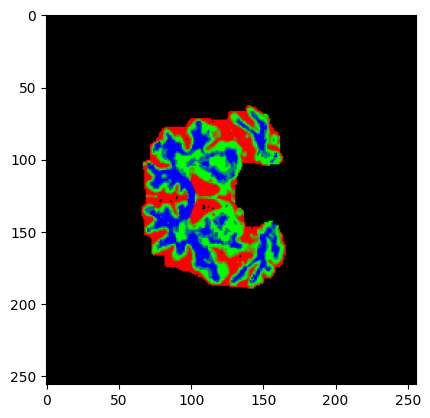

In [18]:
# image = Image.open()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = Image.open("./data/images/AD/coronal/016_S_4583.png")
imgplot = plt.imshow(img)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


(256, 256, 3)

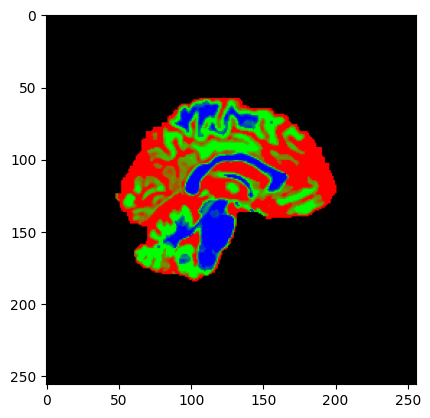

In [47]:
csf = nib.load("./data/MCI/002_S_0729/CSF.nii.gz").get_fdata()[128,:,:]
x,y = csf.shape
csf = csf.reshape(x,y,1)
print(csf.shape)
gm = nib.load("./data/MCI/002_S_0729/GM.nii.gz").get_fdata()[128,:,:]
x,y = gm.shape
gm = gm.reshape(x,y,1)
print(gm.shape)
wm = nib.load("./data/MCI/002_S_0729/WM.nii.gz").get_fdata()[128,:,:]
x,y = wm.shape
wm = wm.reshape(x,y,1)
print(wm.shape)
image = np.concatenate((csf,gm,wm),axis=2)
imgplot = plt.imshow(image)
image.shape

In [ ]:
# 002_S_0729.jpeg

In [14]:
data_dir = './data'
dataset = datasets.ImageFolder(data_dir,
                               transform=transform)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32,
                                         shuffle=True)

FileNotFoundError: Found no valid file for the classes AD, CN, MCI, images. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [18]:
for train, test in kfold.split(PID, labels_OHE):
    #sagital
    train_images = []
    for i in PID[train]:
        csf = nib.load("./"+i+"/CSF.nii.gz").get_fdata()[128,:,:]
        gm = nib.load("./"+i+"/GM.nii.gz").get_fdata()[128,:,:]
        wm = nib.load("./"+i+"/WM.nii.gz").get_fdata()[128,:,:]
        image = np.concatenate((csf,gm,wm),axis=0)
        train_images.append(image)
    train_images = np.array(train_images)
    
    test_images = []
    for i in PID[test]:
        csf = nib.load("./"+i+"/CSF.nii.gz").get_fdata()[128,:,:]
        gm = nib.load("./"+i+"/GM.nii.gz").get_fdata()[128,:,:]
        wm = nib.load("./"+i+"/WM.nii.gz").get_fdata()[128,:,:]
        image = np.concatenate((csf,gm,wm),axis=0)
        test_images.append(image)
    test_images = np.array(test_images)
    
    train_tensor = transform(train_images)
    test_tensor = transform(test_images)
    train_data_loader = DataLoader(train_tensor, batch_size=32, shuffle=True)
    test_data_loader = DataLoader(test_tensor, batch_size=32, shuffle=True)
    print(test_data_loader)
    
    print(test_data_loader.classes)
    

AttributeError: 'DataLoader' object has no attribute 'classes'